<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/adaboost/AdaBoost_test_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
import pdb

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Aquisição dos Dados

In [3]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)
  
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# 2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [4]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


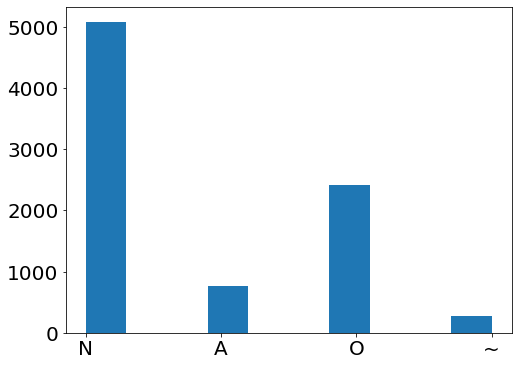

In [5]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

### 2.2 Wavelet helping functions

In [6]:
def gera_filtro_MH(Escala):
  passo = 1/Escala
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

### 2.3 Aplicação da tranformada Wavelet

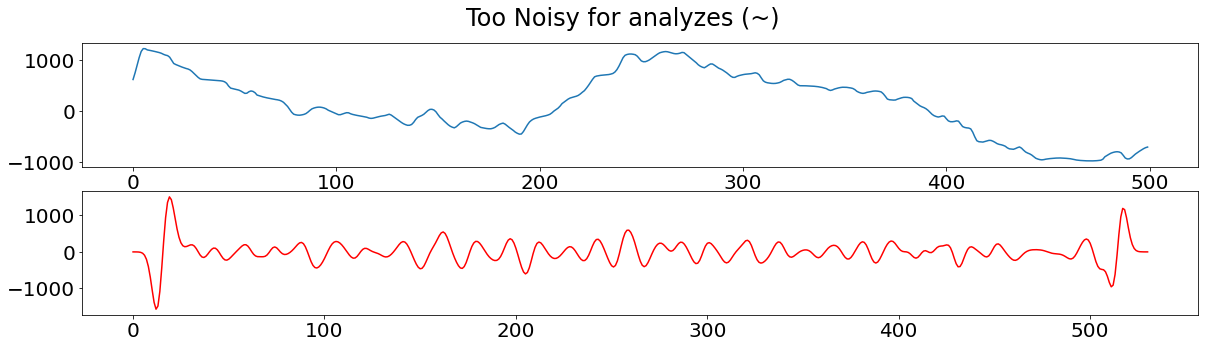

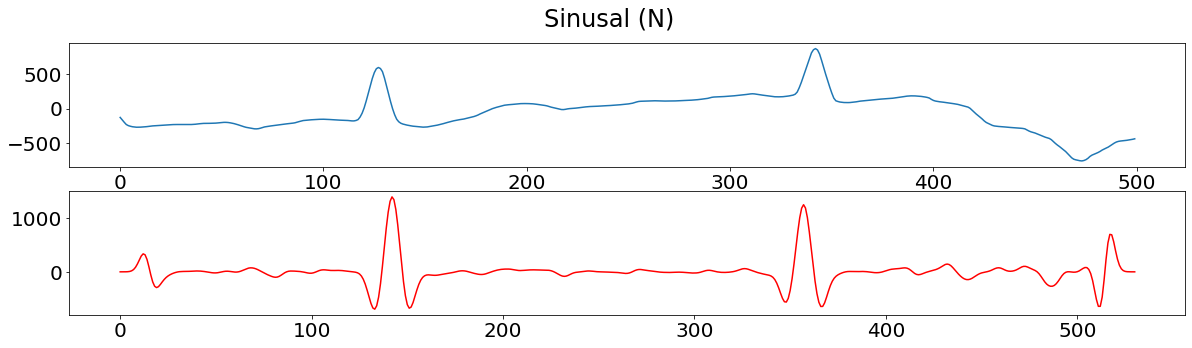

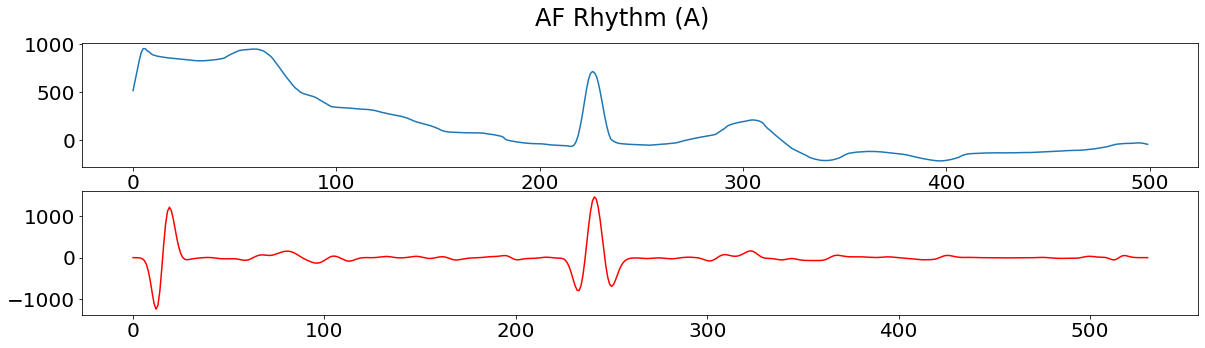

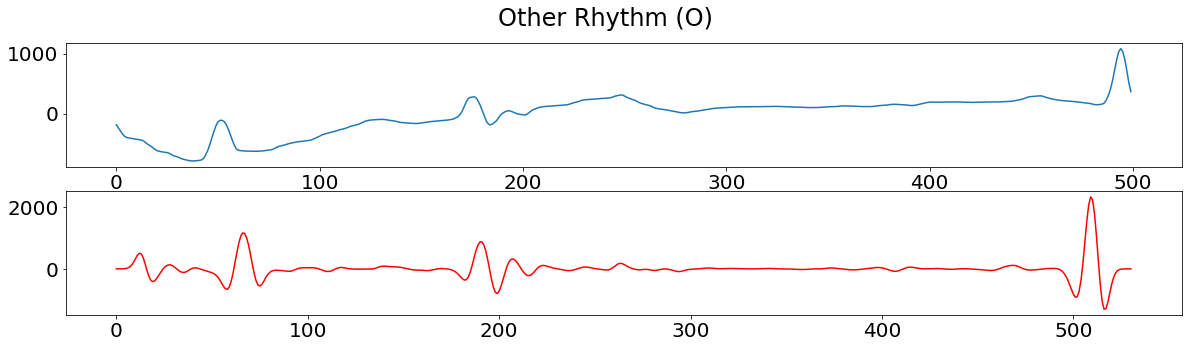

In [7]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == '~'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Too Noisy for analyzes (~)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()


In [8]:
x = []
for i in signals:
  val = apply_wavelet(i, 3)
  x.append(val)

### 2.4 Janelamento dos dados de treino

In [9]:
intersection = 250
window_size = 1000
windows_array = ["max","max","max","max"]
classes_array = ['N', 'O', 'A', '~']

In [10]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection) + 1
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [11]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:

    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [12]:
# x_rem, x_test, y_rem, y_test = train_test_split(x, df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x, df["classes"], test_size=0.1)

d_aux_train = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_train = embalance_data(d_aux_train, classes_array, windows_array, intersection, window_size)

d_aux_valid = pd.DataFrame({'signals': x_valid, 'classes': y_valid})
d_valid = embalance_data(d_aux_valid, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

A saída de streaming foi truncada nas últimas 5000 linhas.
<ipython-input-11-711e6642c52a>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)
<ipython-input-11-711e6642c52a>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)
<ipython-input-11-711e6642c52a>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)
<ipython-input-11-711e6642c52a>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train 

N
Média: 1000.0
Std: 0.0
Qntd: 54216
Min: 1000
---------------
O
Média: 1000.0
Std: 0.0
Qntd: 27724
Min: 1000
---------------
A
Média: 1000.0
Std: 0.0
Qntd: 8122
Min: 1000
---------------
~
Média: 1000.0
Std: 0.0
Qntd: 2276
Min: 1000
---------------


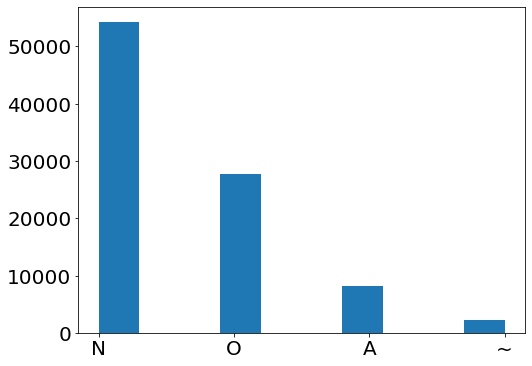

In [13]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
plt.show()

In [14]:
d_train = d_train.sample(frac=1, random_state=1)
signals_2 = d_train["signals"]
classes_2 = d_train["classes"]

### 2.4 "Normalização" do tamanho dos sinais

In [15]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]
# 3. Implementação da CNN

# 3. Implementação do modelo

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [17]:
y_train = classes_2
x_train = list(signals_2)
x_train = np.array(x_train)

x_valid = np.array(list(d_valid["signals"]))
y_valid = d_valid["classes"]
# x_test = np.array(x_test)

In [18]:
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# # x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [19]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [20]:
score_acc = make_scorer(accuracy_score)

In [21]:
def encoder(y):
  columns = pd.get_dummies(y).columns

  for i, x in enumerate(y):
    for j, k in enumerate(columns):
      if x == k:
        y[i] = j
        break

  return np.array(y), columns

In [22]:
def create_cnn():

  input_shape = len(x_train[0])
  k1 = 5
  k2 = 3

  classificador = Sequential()

  for i  in range(0, 6):
    if i == 0:
      classificador.add(Conv1D(filters=64, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
    else:
        classificador.add(Conv1D(filters=64, kernel_size = k1, activation = "relu"))
    # BatchNormalization()
    
    classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
    # BatchNormalization()
    # classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
    classificador.add(MaxPooling1D(pool_size=2))

  classificador.add(Flatten())

  classificador.add(Dense(units=128, activation='relu'))
  classificador.add(Dense(units=64, activation='relu'))
  classificador.add(Dense(units=32, activation='relu'))
  classificador.add(Dense(units=16, activation='relu'))

  classificador.add(Dense(2, activation='softmax'))

  classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])

  return classificador


In [23]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
def print_history(history, n):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy ' + str(n))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    # plt.savefig('plot '+classe+'.png')
    plt.show()

In [25]:
def generate_report(classificador, x_valid, y_valid, columns):
  y_pred = classificador.predict(x_valid)
  y_pred = pd.DataFrame(y_pred)
  y_pred.columns = columns
  y_pred = y_pred.idxmax(axis=1)

  y_valid = pd.DataFrame(y_valid)
  y_valid.columns = columns
  y_valid = y_valid.idxmax(axis=1)

  relatorio = classification_report(y_valid, y_pred) 
  print(relatorio)

In [26]:
class AdaBoost:
    
    def __init__(self, estimator = DecisionTreeClassifier()):
        self.estimator = estimator
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def __not_eq(self, a, b):
      if np.array_equal(a, b):
        return 0
      else:
        return 1

    def __idmax(self, y_pred):
      result = []
      for val in y_pred:
        idx = np.argmax(val)
        aux = np.zeros(len(val))
        aux[idx] = 1
        result.append(aux)

      return np.array(result)

    def __compute_error(self, y, y_pred, w_i):
        error = 0
        for i in range(len(y)):
          error += w_i[i] * self.__not_eq(y[i], y_pred[i])
        error = error/sum(w_i)
        return error

    def __compute_alpha(self, error):
        return np.log((1 - error) / error)

    def __update_weights(self, w_i, alpha, y, y_pred):
        return w_i * np.exp(alpha * (self.__not_eq(y, y_pred)))

    def fit(self, x, y, validation_data=None, M=100, epochs=None, batch_size=None, callbacks=None):

        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = self.__update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m = self.estimator     # Stump: Two terminal-node classification tree
            history = G_m.fit(x, y, sample_weight = w_i, validation_data=validation_data,
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks)
            
            print_history(history, m)

            y_pred = G_m.predict(x)
            y_pred = self.__idmax(y_pred)
            
            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = self.__compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = self.__compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

    def predict(self, x):

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(x)), columns = range(self.M)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(x) * self.alphas[m]
            for i in range(weak_preds.shape[0]):
              weak_preds.iloc[i,m] = y_pred_m[i]

        # Calculate final predictions
        y_pred = weak_preds.T.sum()
        y_pred =  self.__idmax(y_pred)

        return y_pred

In [27]:
def build_adaboost(x_train, y_train, x_valid, y_valid):

  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
  y_train = pd.get_dummies(y_train)
  columns = y_train.columns
  y_train = np.array(y_train, dtype=int)

  print(columns)

  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
  y_valid = pd.get_dummies(y_valid)
  y_valid = np.array(y_valid, dtype=int)

  es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=15)

  model = create_cnn()

  adaboost = AdaBoost(estimator = model)
  
  history = adaboost.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                         M=5, epochs=30, batch_size=128, callbacks=es)
  
  generate_report(adaboost, x_valid, y_valid, columns)

  return columns, adaboost

# 4. Implementação da árvore

In [28]:
# x_train = x_train[0:200]
# y_train = y_train[0:200]

In [29]:
class RootNode:
  def __init__(self):
    self.child = None

In [30]:
class BinaryTreeNode:
  def __init__(self, model, classe):
    self.columns = None
    self.classe = classe
    self.model = model
    self.leftChild = None
    self.rightChild=None

In [31]:
# def print_history(history, classe, classificador, x_valid, y_valid, columns):
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('accuracy '+classe)
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'valid'], loc='upper left')
#     plt.savefig('plot '+classe+'.png')
#     plt.show()

#     y_pred = classificador.predict(x_valid)
#     y_pred = pd.DataFrame(y_pred)
#     y_pred.columns = columns

#     y_pred = y_pred.idxmax(axis=1)
#     relatorio = classification_report(y_valid, y_pred) 
#     print(relatorio)

In [32]:
def build_tree(x_train, y_train, x_valid, y_valid, classes_array, father):  

  if len(classes_array) < 2:
    print("impossivel classificar")
    return

  minority = classes_array[0]
  del classes_array[0]

  if len(classes_array) != 1:
    y_next = y_train.replace(classes_array, "nan")
    y_next_val = y_valid.replace(classes_array, "nan")
  else:
    y_next = y_train
    y_next_val = y_valid

  columns, model = build_adaboost(x_train, y_next, x_valid, y_next_val)
  node = BinaryTreeNode(model=model, classe="nan")
  node.leftChild = BinaryTreeNode(model=None, classe=minority)
  node.columns = columns

  # print_history(history, minority, model, x_valid, y_next_val, columns)

  if type(father) == RootNode:
    father.child = node
  else:
    father.rightChild = node

  if len(classes_array) == 1:
    node.rightChild = BinaryTreeNode(model=None, classe=classes_array[0])
  else:
    aux_df = pd.DataFrame({"signals": list(x_train), "classes": y_train})
    aux_df_valid = pd.DataFrame({"signals": list(x_valid), "classes": y_valid})

    aux_df.drop(aux_df[aux_df['classes'] == minority].index, inplace=True)
    aux_df_valid.drop(aux_df_valid[aux_df_valid['classes'] == minority].index, inplace=True)

    x_next = np.array(list(aux_df["signals"]))
    x_next_val = np.array(list(aux_df_valid["signals"]))

    y_next = aux_df["classes"]
    y_next_val = aux_df_valid["classes"]
    
    build_tree(x_next, y_next, x_next_val, y_next_val, classes_array, node) 


Index(['A', 'nan'], dtype='object')
Epoch 1/30
722/722 [==============================] - 52s 49ms/step - loss: 6.3669e-06 - accuracy: 0.9121 - val_loss: 0.2253 - val_accuracy: 0.9072
Epoch 2/30
722/722 [==============================] - 33s 45ms/step - loss: 2.1732e-06 - accuracy: 0.9192 - val_loss: 0.1911 - val_accuracy: 0.9241
Epoch 3/30
722/722 [==============================] - 33s 46ms/step - loss: 1.9373e-06 - accuracy: 0.9291 - val_loss: 0.1742 - val_accuracy: 0.9334
Epoch 4/30
722/722 [==============================] - 32s 45ms/step - loss: 1.8057e-06 - accuracy: 0.9339 - val_loss: 0.1660 - val_accuracy: 0.9372
Epoch 5/30
722/722 [==============================] - 32s 45ms/step - loss: 1.6991e-06 - accuracy: 0.9400 - val_loss: 0.1757 - val_accuracy: 0.9379
Epoch 6/30
722/722 [==============================] - 33s 45ms/step - loss: 1.6257e-06 - accuracy: 0.9434 - val_loss: 0.1677 - val_accuracy: 0.9385
Epoch 7/30
722/722 [==============================] - 33s 45ms/step - loss: 

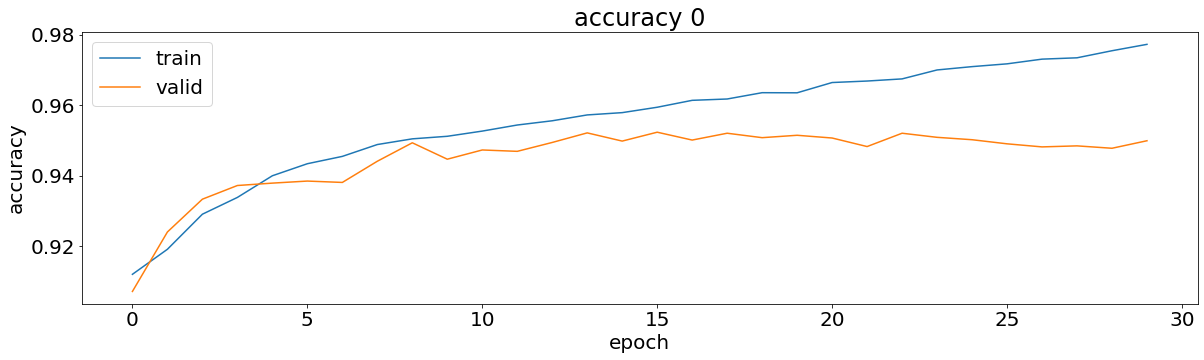

2886/2886 [==============================] - 15s 5ms/step
Epoch 1/30
722/722 [==============================] - 33s 45ms/step - loss: 5.9730e-05 - accuracy: 0.9632 - val_loss: 0.1581 - val_accuracy: 0.9476
Epoch 2/30
722/722 [==============================] - 32s 45ms/step - loss: 5.3927e-05 - accuracy: 0.9669 - val_loss: 0.1548 - val_accuracy: 0.9456
Epoch 3/30
722/722 [==============================] - 32s 44ms/step - loss: 5.2723e-05 - accuracy: 0.9658 - val_loss: 0.1733 - val_accuracy: 0.9488
Epoch 4/30
722/722 [==============================] - 32s 45ms/step - loss: 4.9064e-05 - accuracy: 0.9694 - val_loss: 0.1838 - val_accuracy: 0.9464
Epoch 5/30
722/722 [==============================] - 32s 45ms/step - loss: 4.5124e-05 - accuracy: 0.9710 - val_loss: 0.2128 - val_accuracy: 0.9510
Epoch 6/30
722/722 [==============================] - 32s 45ms/step - loss: 4.2812e-05 - accuracy: 0.9729 - val_loss: 0.1644 - val_accuracy: 0.9480
Epoch 7/30
722/722 [==============================] - 

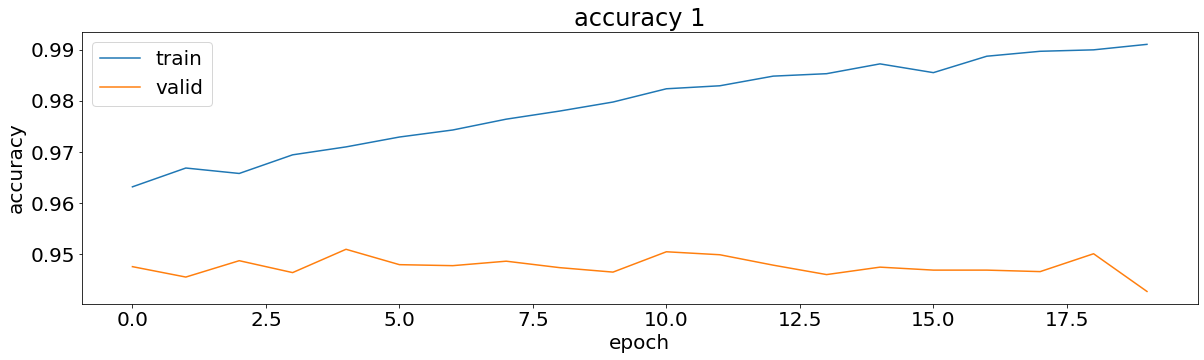

2886/2886 [==============================] - 13s 5ms/step
Epoch 1/30
722/722 [==============================] - 33s 45ms/step - loss: 0.0030 - accuracy: 0.9849 - val_loss: 0.4296 - val_accuracy: 0.9449
Epoch 2/30
722/722 [==============================] - 32s 44ms/step - loss: 0.0020 - accuracy: 0.9901 - val_loss: 0.3659 - val_accuracy: 0.9476
Epoch 3/30
722/722 [==============================] - 32s 44ms/step - loss: 0.0017 - accuracy: 0.9918 - val_loss: 0.3804 - val_accuracy: 0.9414
Epoch 4/30
722/722 [==============================] - 32s 44ms/step - loss: 0.0016 - accuracy: 0.9919 - val_loss: 0.4092 - val_accuracy: 0.9499
Epoch 5/30
722/722 [==============================] - 32s 44ms/step - loss: 0.0016 - accuracy: 0.9923 - val_loss: 0.4808 - val_accuracy: 0.9473
Epoch 6/30
722/722 [==============================] - 32s 44ms/step - loss: 0.0015 - accuracy: 0.9933 - val_loss: 0.5506 - val_accuracy: 0.9450
Epoch 7/30
722/722 [==============================] - 32s 44ms/step - loss: 0.

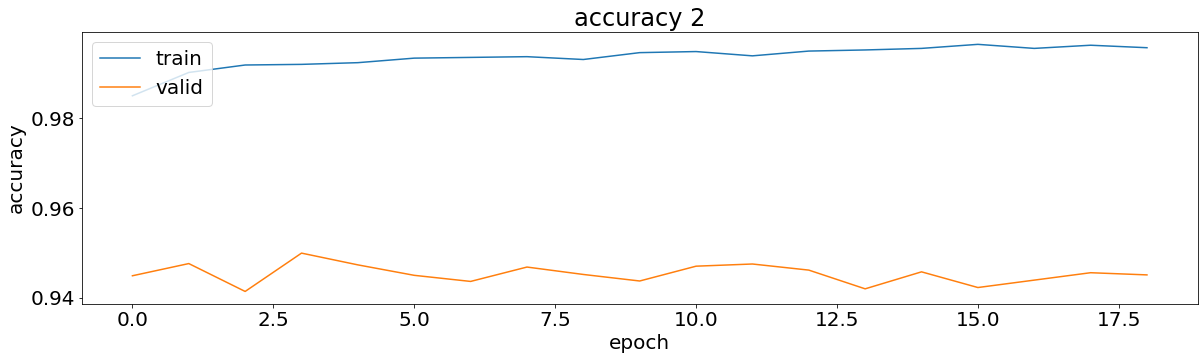

2886/2886 [==============================] - 13s 5ms/step
Epoch 1/30
722/722 [==============================] - 32s 45ms/step - loss: 0.7570 - accuracy: 0.9928 - val_loss: 0.4749 - val_accuracy: 0.9435
Epoch 2/30
722/722 [==============================] - 32s 44ms/step - loss: 0.3844 - accuracy: 0.9964 - val_loss: 0.5960 - val_accuracy: 0.9467
Epoch 3/30
722/722 [==============================] - 32s 44ms/step - loss: 0.3910 - accuracy: 0.9967 - val_loss: 0.5941 - val_accuracy: 0.9460
Epoch 4/30
722/722 [==============================] - 32s 44ms/step - loss: 0.3841 - accuracy: 0.9963 - val_loss: 0.9935 - val_accuracy: 0.9470
Epoch 5/30
722/722 [==============================] - 32s 44ms/step - loss: 0.4300 - accuracy: 0.9958 - val_loss: 0.5338 - val_accuracy: 0.9457
Epoch 6/30
722/722 [==============================] - 32s 44ms/step - loss: 0.4155 - accuracy: 0.9960 - val_loss: 0.4291 - val_accuracy: 0.9432
Epoch 7/30
722/722 [==============================] - 32s 44ms/step - loss: 0.

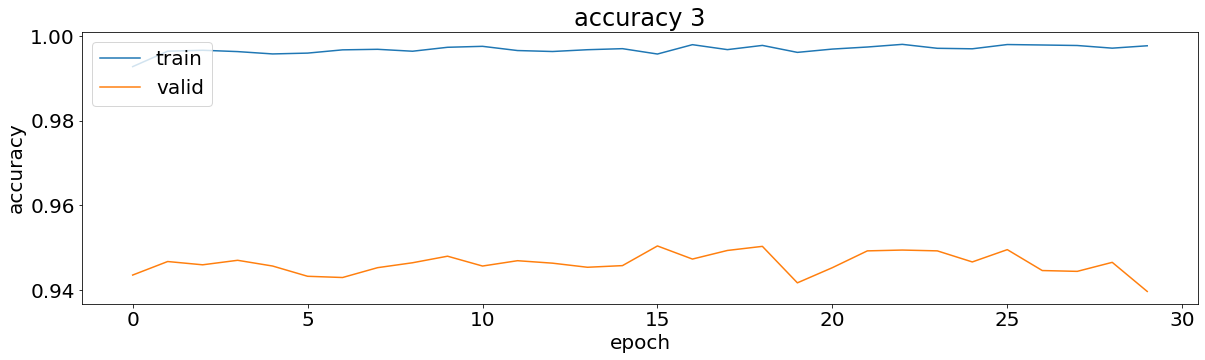

2886/2886 [==============================] - 14s 5ms/step
Epoch 1/30
722/722 [==============================] - 32s 44ms/step - loss: 209.4741 - accuracy: 0.9933 - val_loss: 0.6710 - val_accuracy: 0.9497
Epoch 2/30
722/722 [==============================] - 32s 44ms/step - loss: 65.7881 - accuracy: 0.9982 - val_loss: 0.5813 - val_accuracy: 0.9477
Epoch 3/30
722/722 [==============================] - 32s 44ms/step - loss: 76.4585 - accuracy: 0.9974 - val_loss: 0.4439 - val_accuracy: 0.9422
Epoch 4/30
722/722 [==============================] - 32s 44ms/step - loss: 105.1276 - accuracy: 0.9968 - val_loss: 0.5208 - val_accuracy: 0.9468
Epoch 5/30
722/722 [==============================] - 32s 44ms/step - loss: 66.5116 - accuracy: 0.9980 - val_loss: 0.7796 - val_accuracy: 0.9478
Epoch 6/30
722/722 [==============================] - 32s 44ms/step - loss: 71.7292 - accuracy: 0.9979 - val_loss: 0.8513 - val_accuracy: 0.9456
Epoch 7/30
722/722 [==============================] - 32s 44ms/step - 

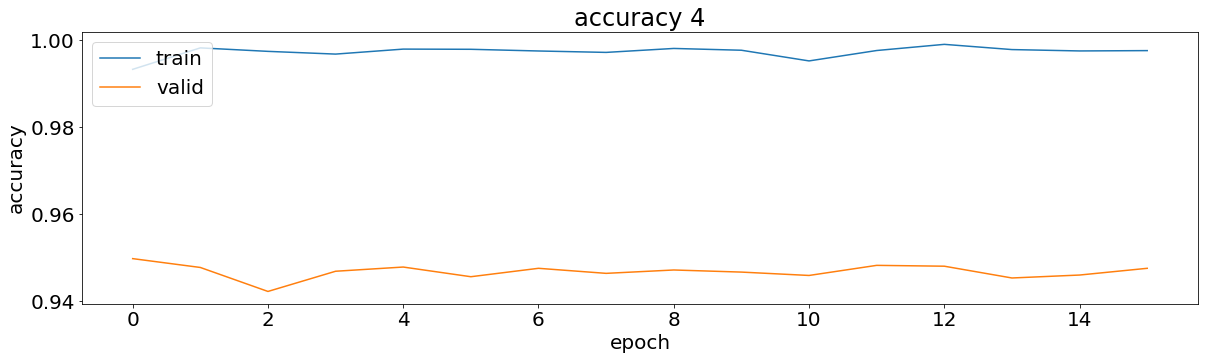

323/323 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           A       0.75      0.64      0.69       957
         nan       0.96      0.98      0.97      9368

    accuracy                           0.95     10325
   macro avg       0.86      0.81      0.83     10325
weighted avg       0.94      0.95      0.95     10325

Index(['O', 'nan'], dtype='object')
Epoch 1/30
658/658 [==============================] - 39s 52ms/step - loss: 7.1786e-06 - accuracy: 0.7135 - val_loss: 0.5893 - val_accuracy: 0.7245
Epoch 2/30
658/658 [==============================] - 30s 45ms/step - loss: 6.2521e-06 - accuracy: 0.7629 - val_loss: 0.5345 - val_accuracy: 0.7657
Epoch 3/30
658/658 [==============================] - 30s 45ms/step - loss: 5.9859e-06 - accuracy: 0.7752 - val_loss: 0.5126 - val_accuracy: 0.7719
Epoch 4/30
658/658 [==============================] - 30s 45ms/step - loss: 5.8101e-06 - accuracy: 0.7842 - val_loss: 0.5116 - val_accurac

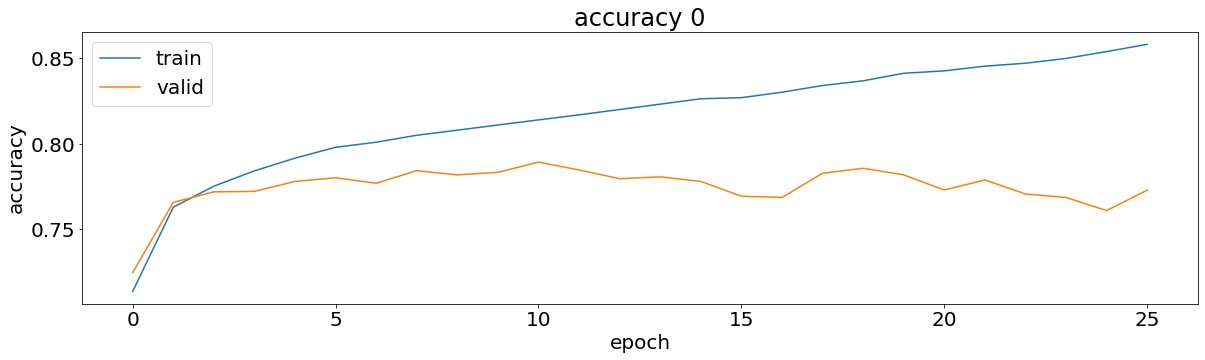

2632/2632 [==============================] - 13s 5ms/step
Epoch 1/30
658/658 [==============================] - 30s 45ms/step - loss: 3.1180e-05 - accuracy: 0.8411 - val_loss: 0.5681 - val_accuracy: 0.7744
Epoch 2/30
658/658 [==============================] - 30s 45ms/step - loss: 2.9893e-05 - accuracy: 0.8471 - val_loss: 0.5681 - val_accuracy: 0.7749
Epoch 3/30
658/658 [==============================] - 29s 44ms/step - loss: 2.9462e-05 - accuracy: 0.8506 - val_loss: 0.6042 - val_accuracy: 0.7730
Epoch 4/30
658/658 [==============================] - 29s 45ms/step - loss: 2.8507e-05 - accuracy: 0.8571 - val_loss: 0.6465 - val_accuracy: 0.7796
Epoch 5/30
658/658 [==============================] - 29s 45ms/step - loss: 2.7748e-05 - accuracy: 0.8605 - val_loss: 0.6191 - val_accuracy: 0.7711
Epoch 6/30
658/658 [==============================] - 29s 45ms/step - loss: 2.6860e-05 - accuracy: 0.8658 - val_loss: 0.6098 - val_accuracy: 0.7697
Epoch 7/30
658/658 [==============================] - 

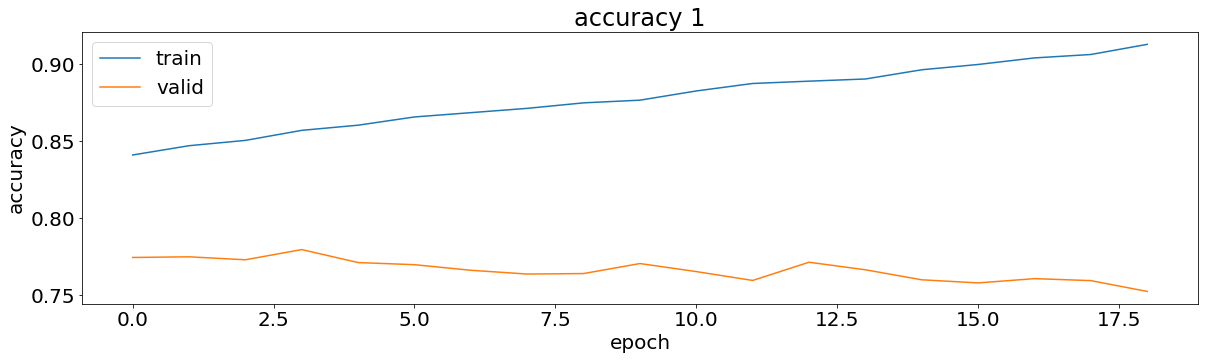

2632/2632 [==============================] - 12s 5ms/step
Epoch 1/30
658/658 [==============================] - 30s 45ms/step - loss: 2.3314e-04 - accuracy: 0.8994 - val_loss: 0.9846 - val_accuracy: 0.7638
Epoch 2/30
658/658 [==============================] - 30s 45ms/step - loss: 2.0333e-04 - accuracy: 0.9118 - val_loss: 1.0798 - val_accuracy: 0.7450
Epoch 3/30
658/658 [==============================] - 29s 44ms/step - loss: 1.9408e-04 - accuracy: 0.9166 - val_loss: 1.1638 - val_accuracy: 0.7483
Epoch 4/30
658/658 [==============================] - 29s 44ms/step - loss: 1.8673e-04 - accuracy: 0.9201 - val_loss: 1.0699 - val_accuracy: 0.7498
Epoch 5/30
658/658 [==============================] - 29s 45ms/step - loss: 1.7737e-04 - accuracy: 0.9244 - val_loss: 1.2073 - val_accuracy: 0.7466
Epoch 6/30
658/658 [==============================] - 29s 44ms/step - loss: 1.6491e-04 - accuracy: 0.9291 - val_loss: 1.1523 - val_accuracy: 0.7495
Epoch 7/30
658/658 [==============================] - 

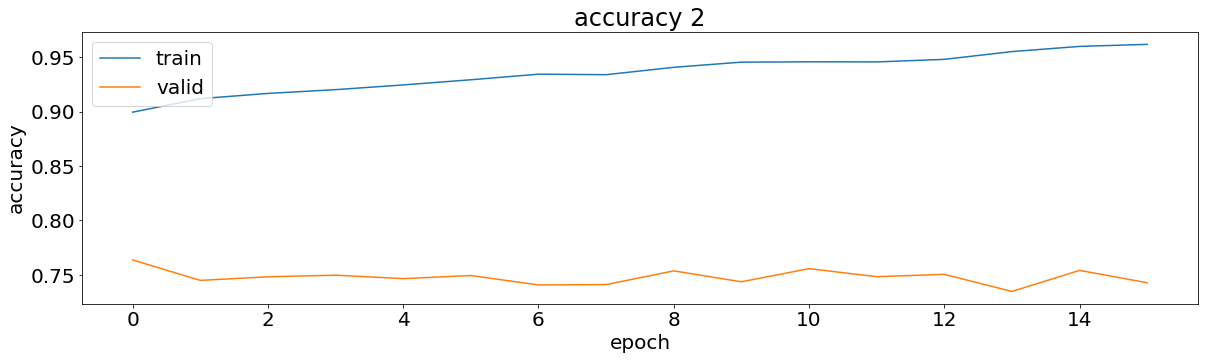

2632/2632 [==============================] - 12s 5ms/step
Epoch 1/30
658/658 [==============================] - 30s 45ms/step - loss: 0.0046 - accuracy: 0.9462 - val_loss: 1.8450 - val_accuracy: 0.7217
Epoch 2/30
658/658 [==============================] - 29s 45ms/step - loss: 0.0032 - accuracy: 0.9626 - val_loss: 1.5023 - val_accuracy: 0.7507
Epoch 3/30
658/658 [==============================] - 29s 44ms/step - loss: 0.0034 - accuracy: 0.9615 - val_loss: 1.6419 - val_accuracy: 0.7437
Epoch 4/30
658/658 [==============================] - 29s 44ms/step - loss: 0.0031 - accuracy: 0.9655 - val_loss: 1.6800 - val_accuracy: 0.7414
Epoch 5/30
658/658 [==============================] - 29s 44ms/step - loss: 0.0027 - accuracy: 0.9701 - val_loss: 1.7557 - val_accuracy: 0.7356
Epoch 6/30
658/658 [==============================] - 29s 44ms/step - loss: 0.0029 - accuracy: 0.9673 - val_loss: 1.6827 - val_accuracy: 0.7393
Epoch 7/30
658/658 [==============================] - 29s 44ms/step - loss: 0.

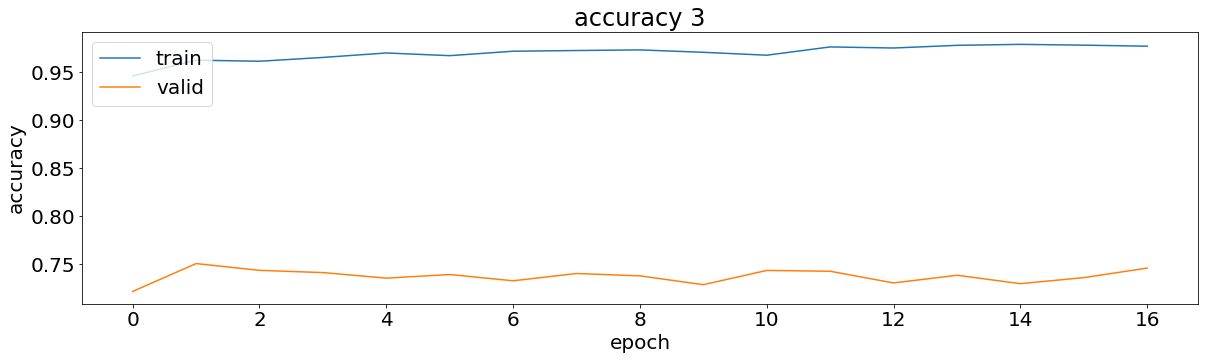

2632/2632 [==============================] - 12s 5ms/step
Epoch 1/30
658/658 [==============================] - 30s 45ms/step - loss: 0.2117 - accuracy: 0.9630 - val_loss: 1.8731 - val_accuracy: 0.7238
Epoch 2/30
658/658 [==============================] - 29s 45ms/step - loss: 0.1356 - accuracy: 0.9766 - val_loss: 1.8370 - val_accuracy: 0.7357
Epoch 3/30
658/658 [==============================] - 29s 44ms/step - loss: 0.1036 - accuracy: 0.9823 - val_loss: 2.9795 - val_accuracy: 0.7258
Epoch 4/30
658/658 [==============================] - 29s 44ms/step - loss: 0.1192 - accuracy: 0.9802 - val_loss: 3.0648 - val_accuracy: 0.7392
Epoch 5/30
658/658 [==============================] - 29s 44ms/step - loss: 0.0957 - accuracy: 0.9843 - val_loss: 2.4736 - val_accuracy: 0.7436
Epoch 6/30
658/658 [==============================] - 29s 44ms/step - loss: 0.0970 - accuracy: 0.9841 - val_loss: 2.6996 - val_accuracy: 0.7399
Epoch 7/30
658/658 [==============================] - 29s 44ms/step - loss: 0.

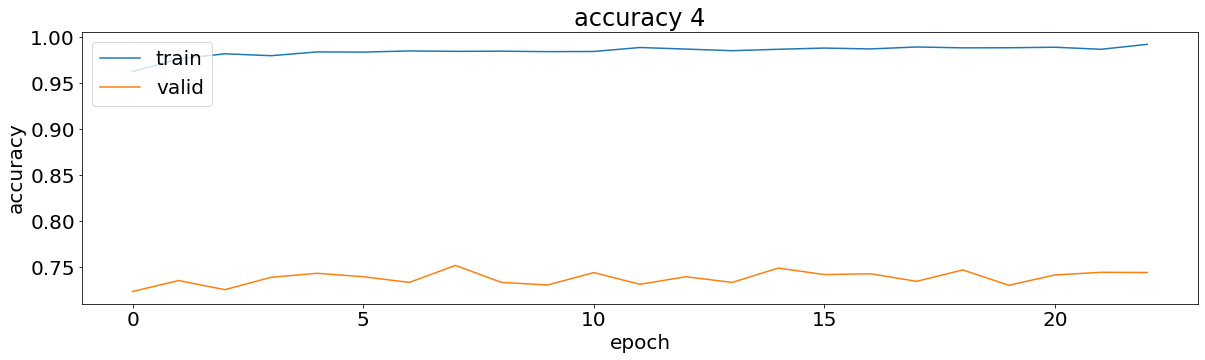

293/293 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           O       0.63      0.54      0.58      3074
         nan       0.79      0.84      0.82      6294

    accuracy                           0.74      9368
   macro avg       0.71      0.69      0.70      9368
weighted avg       0.74      0.74      0.74      9368

Index(['N', '~'], dtype='object')
Epoch 1/30
442/442 [==============================] - 28s 54ms/step - loss: 1.9506e-05 - accuracy: 0.9620 - val_loss: 0.1091 - val_accuracy: 0.9716
Epoch 2/30
442/442 [==============================] - 20s 46ms/step - loss: 1.8710e-06 - accuracy: 0.9636 - val_loss: 0.0854 - val_accuracy: 0.9716
Epoch 3/30
442/442 [==============================] - 20s 45ms/step - loss: 1.7640e-06 - accuracy: 0.9653 - val_loss: 0.0751 - val_accuracy: 0.9733
Epoch 4/30
442/442 [==============================] - 20s 45ms/step - loss: 1.7314e-06 - accuracy: 0.9669 - val_loss: 0.0805 - val_accuracy:

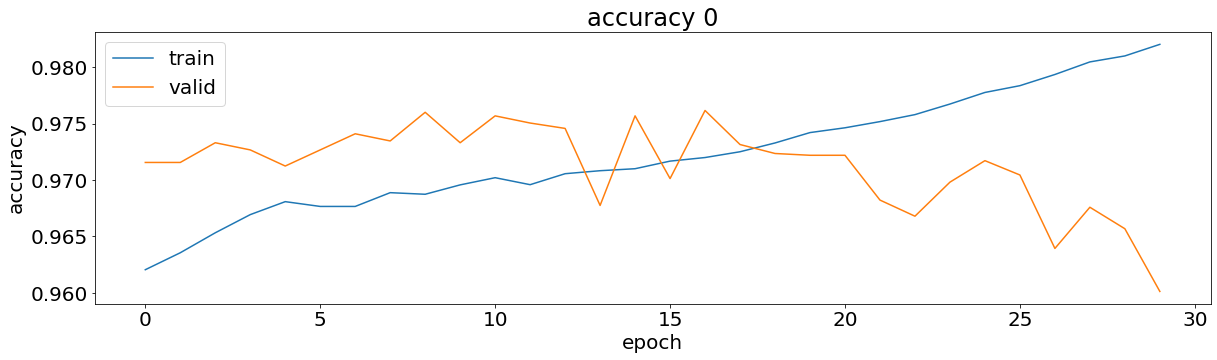

1766/1766 [==============================] - 9s 5ms/step
Epoch 1/30
442/442 [==============================] - 20s 45ms/step - loss: 8.9518e-05 - accuracy: 0.9746 - val_loss: 0.0862 - val_accuracy: 0.9725
Epoch 2/30
442/442 [==============================] - 20s 45ms/step - loss: 7.8924e-05 - accuracy: 0.9775 - val_loss: 0.0845 - val_accuracy: 0.9727
Epoch 3/30
442/442 [==============================] - 20s 45ms/step - loss: 7.2925e-05 - accuracy: 0.9790 - val_loss: 0.1040 - val_accuracy: 0.9670
Epoch 4/30
442/442 [==============================] - 19s 44ms/step - loss: 6.8995e-05 - accuracy: 0.9798 - val_loss: 0.1069 - val_accuracy: 0.9662
Epoch 5/30
442/442 [==============================] - 20s 44ms/step - loss: 6.7757e-05 - accuracy: 0.9805 - val_loss: 0.0983 - val_accuracy: 0.9698
Epoch 6/30
442/442 [==============================] - 20s 44ms/step - loss: 5.8875e-05 - accuracy: 0.9838 - val_loss: 0.1080 - val_accuracy: 0.9706
Epoch 7/30
442/442 [==============================] - 2

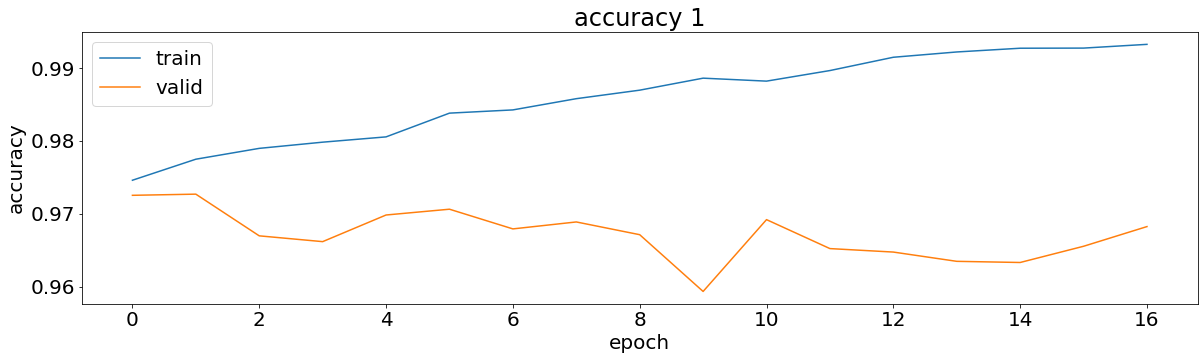

1766/1766 [==============================] - 8s 5ms/step
Epoch 1/30
442/442 [==============================] - 20s 45ms/step - loss: 0.0077 - accuracy: 0.9889 - val_loss: 0.1305 - val_accuracy: 0.9684
Epoch 2/30
442/442 [==============================] - 20s 45ms/step - loss: 0.0050 - accuracy: 0.9928 - val_loss: 0.1871 - val_accuracy: 0.9685
Epoch 3/30
442/442 [==============================] - 19s 44ms/step - loss: 0.0039 - accuracy: 0.9937 - val_loss: 0.1793 - val_accuracy: 0.9654
Epoch 4/30
442/442 [==============================] - 19s 44ms/step - loss: 0.0037 - accuracy: 0.9946 - val_loss: 0.2074 - val_accuracy: 0.9658
Epoch 5/30
442/442 [==============================] - 20s 44ms/step - loss: 0.0033 - accuracy: 0.9950 - val_loss: 0.2057 - val_accuracy: 0.9641
Epoch 6/30
442/442 [==============================] - 20s 44ms/step - loss: 0.0033 - accuracy: 0.9948 - val_loss: 0.2086 - val_accuracy: 0.9631
Epoch 7/30
442/442 [==============================] - 20s 44ms/step - loss: 0.0

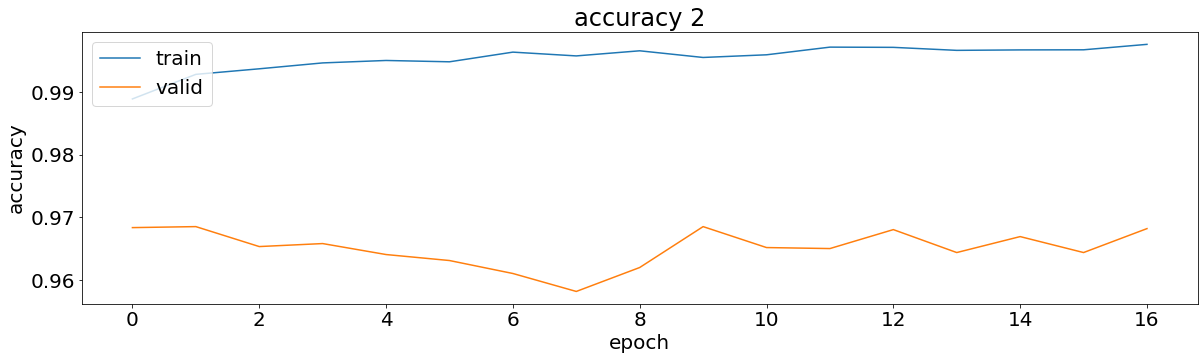

1766/1766 [==============================] - 8s 5ms/step
Epoch 1/30
442/442 [==============================] - 20s 45ms/step - loss: 1.7704 - accuracy: 0.9927 - val_loss: 0.2289 - val_accuracy: 0.9693
Epoch 2/30
442/442 [==============================] - 20s 45ms/step - loss: 1.0600 - accuracy: 0.9956 - val_loss: 0.2484 - val_accuracy: 0.9670
Epoch 3/30
442/442 [==============================] - 19s 44ms/step - loss: 0.7331 - accuracy: 0.9970 - val_loss: 0.2798 - val_accuracy: 0.9649
Epoch 4/30
442/442 [==============================] - 19s 44ms/step - loss: 0.7936 - accuracy: 0.9970 - val_loss: 0.1854 - val_accuracy: 0.9685
Epoch 5/30
442/442 [==============================] - 20s 44ms/step - loss: 0.8354 - accuracy: 0.9971 - val_loss: 0.3002 - val_accuracy: 0.9643
Epoch 6/30
442/442 [==============================] - 20s 44ms/step - loss: 0.6878 - accuracy: 0.9975 - val_loss: 0.2356 - val_accuracy: 0.9695
Epoch 7/30
442/442 [==============================] - 20s 44ms/step - loss: 0.4

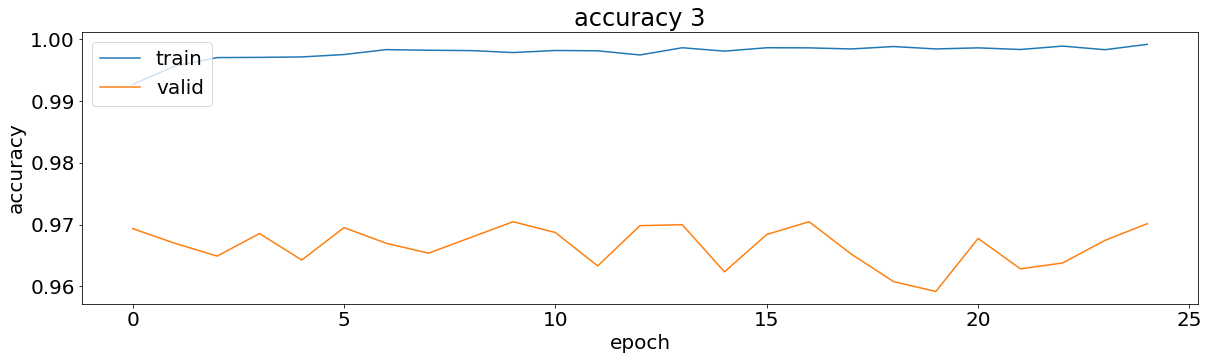

1766/1766 [==============================] - 8s 5ms/step
Epoch 1/30
442/442 [==============================] - 20s 44ms/step - loss: 1192.3677 - accuracy: 0.9957 - val_loss: 0.4254 - val_accuracy: 0.9603
Epoch 2/30
442/442 [==============================] - 20s 45ms/step - loss: 546.9065 - accuracy: 0.9978 - val_loss: 0.2231 - val_accuracy: 0.9674
Epoch 3/30
442/442 [==============================] - 19s 44ms/step - loss: 841.9348 - accuracy: 0.9979 - val_loss: 0.2675 - val_accuracy: 0.9665
Epoch 4/30
442/442 [==============================] - 19s 44ms/step - loss: 272.8765 - accuracy: 0.9989 - val_loss: 0.2801 - val_accuracy: 0.9654
Epoch 5/30
442/442 [==============================] - 19s 44ms/step - loss: 260.1053 - accuracy: 0.9989 - val_loss: 0.3111 - val_accuracy: 0.9657
Epoch 6/30
442/442 [==============================] - 20s 44ms/step - loss: 537.9181 - accuracy: 0.9983 - val_loss: 0.3433 - val_accuracy: 0.9649
Epoch 7/30
442/442 [==============================] - 20s 44ms/ste

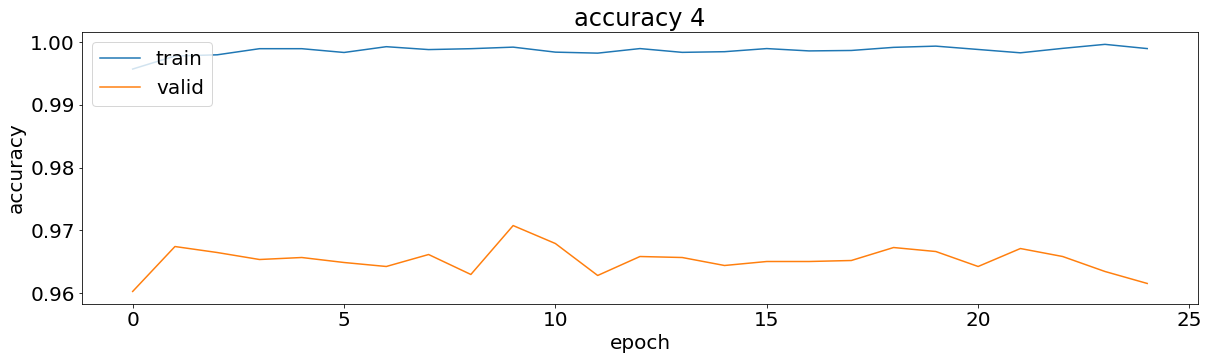

197/197 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           N       0.98      0.98      0.98      6107
           ~       0.38      0.49      0.43       187

    accuracy                           0.96      6294
   macro avg       0.68      0.73      0.71      6294
weighted avg       0.97      0.96      0.96      6294



In [33]:
classes_array = ['A', 'O', 'N', '~']
# [classes_array.append(item) for item in y_train if item not in classes_array]
root = RootNode()
build_tree(x_train, y_train,x_valid, y_valid, classes_array, root)

In [34]:
def make_prediction(current_node, samples):
    if type(current_node) == RootNode:
        current_node = current_node.child

    samples = window(signal, intersection, window_size, "max")
    samples = np.array(samples)
    samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

    while current_node.model != None:
        model = current_node.model
        prediction = model.predict(samples)
        prediction = pd.DataFrame(prediction)
        prediction.columns = current_node.columns
        prediction = prediction.idxmax(axis=1)
        prediction = prediction.mode()[0]
        # print(prediction)

        if prediction == current_node.leftChild.classe:
            current_node = current_node.leftChild
        elif prediction == current_node.rightChild.classe:
            current_node = current_node.rightChild

    return current_node.classe

In [35]:
y_pred = []
for signal in d_aux_valid["signals"]:
    prediction = make_prediction(root, signal)
    y_pred.append(prediction)

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 26ms/step


In [36]:
classes_list = []
for i in y_valid:
    if i not in classes_list:
        classes_list.append(i)

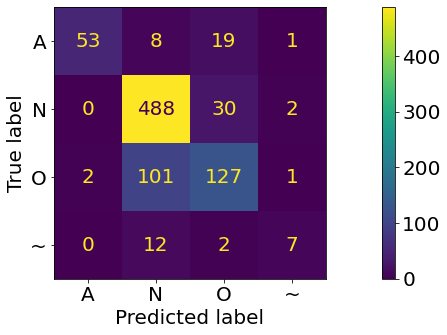

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(d_aux_valid["classes"], y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A','N','O','~'])
cm_display.plot()
plt.savefig("drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/valid.png")

In [38]:
relatorio = classification_report(d_aux_valid["classes"], y_pred)
print(relatorio)

              precision    recall  f1-score   support

           A       0.96      0.65      0.78        81
           N       0.80      0.94      0.86       520
           O       0.71      0.55      0.62       231
           ~       0.64      0.33      0.44        21

    accuracy                           0.79       853
   macro avg       0.78      0.62      0.68       853
weighted avg       0.79      0.79      0.78       853

